In [14]:
class_names=["Fat", "Muscular", "Vein", "Gland", "Stroma", "Tumor", "Necrosis", "Epithelium"]
nclasses=len(class_names)
in_channels= 3  #input channel of the data, RGB = 3



# --- training params
batch_size=256
patch_size=64 #currently, this needs to be 224 due to densenet architecture
num_epochs = 250
phases = ["train","val"] #how many phases did we create databases for?
#validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up
validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up    

In [15]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import DenseNet
from torchsummary import summary

from albumentations import *
from albumentations.pytorch import ToTensor

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob
import scipy
from tensorboardX import SummaryWriter

from tqdm.autonotebook import tqdm


import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

In [16]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [17]:
gpuid=0
#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11018MB, multi_processor_count=68)


In [18]:
class SmallNetwork(nn.Module):
    def __init__(self):
        super(SmallNetwork,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, padding = 1),
            nn.ReLU(True),
            nn.BatchNorm2d(6),
            nn.Conv2d(6, 6, kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(6),
            nn.Conv2d(6,8,stride=2,kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8,8,stride=2,kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8,8,stride=2,kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8)
        )


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        

        self.final= nn.Sequential(
            nn.Linear(8, 16), #--- add dropout
            nn.ReLU(True),
            nn.BatchNorm1d(16),
            nn.Linear(16, 16),
            nn.ReLU(True),
            nn.Linear(16, nclasses),
        )
                          

        
    def forward(self,x):
        x = self.encoder(x)
        #x = self.decoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x , 1)
        x = self.final(x)
        return x

In [19]:
device = torch.device('cuda')
model = SmallNetwork().to(device)

summary(model, input_size=(3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 64, 64]             168
              ReLU-2            [-1, 6, 64, 64]               0
       BatchNorm2d-3            [-1, 6, 64, 64]              12
            Conv2d-4            [-1, 6, 62, 62]             330
              ReLU-5            [-1, 6, 62, 62]               0
       BatchNorm2d-6            [-1, 6, 62, 62]              12
            Conv2d-7            [-1, 8, 30, 30]             440
              ReLU-8            [-1, 8, 30, 30]               0
       BatchNorm2d-9            [-1, 8, 30, 30]              16
           Conv2d-10            [-1, 8, 14, 14]             584
             ReLU-11            [-1, 8, 14, 14]               0
      BatchNorm2d-12            [-1, 8, 14, 14]              16
           Conv2d-13              [-1, 8, 6, 6]             584
             ReLU-14              [-1, 

In [20]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.imgs.shape[0]
        
        self.imgs = None
        self.labels = None
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here. need to do it everytime, otherwise hdf5 crashes

        with tables.open_file(self.fname,'r') as db:
            self.imgs=db.root.imgs
            self.labels=db.root.labels

            #get the requested image and mask from the pytable
            img = self.imgs[index,:,:,:]
            label = self.labels[index]
        
        
        img_new = img
        if self.img_transform:
            img_new = self.img_transform(image=img)['image']
        

        return img_new, label, img
    def __len__(self):
        return self.nitems

In [21]:
img_transform={}
#img_transform["train"] = Compose([
#       VerticalFlip(p=.5),
#       HorizontalFlip(p=.5),
#       GaussNoise(),
#       GaussianBlur(),
#       #HueSaturationValue(hue_shift_limit=(-25,0),sat_shift_limit=0,val_shift_limit=0,p=1),
#       Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
#       #ElasticTransform(always_apply=True, approximate=True, alpha=150, sigma=8,alpha_affine=50),
#       #RandomSizedCrop((patch_size,patch_size), patch_size,patch_size),
#       ToTensor()
#    ])


img_transform['train'] = Compose([
        #RandomScale(scale_limit=0.1,p=.9),
        #PadIfNeeded(min_height=patch_size,min_width=patch_size),        
        VerticalFlip(p=.5),
        HorizontalFlip(p=.5),
        #Blur(p=.5),
        #Downscale(p=.25, scale_min=0.64, scale_max=0.99),
        #GaussNoise(p=.5, var_limit=(10.0, 50.0)),
        #GridDistortion(p=.5, num_steps=5, distort_limit=(-0.3, 0.3),
                     #  border_mode=cv2.BORDER_REFLECT),
        #ISONoise(p=.5, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
        RandomBrightness(p=.5, limit=(-0.2, 0.2)),
        #RandomContrast(p=.5, limit=(-0.2, 0.2)),
        #RandomGamma(p=.5, gamma_limit=(80, 120), eps=1e-07),
        #MultiplicativeNoise(p=.5, multiplier=(0.9, 1.1), per_channel=True, elementwise=True),
        #HueSaturationValue(hue_shift_limit=20,sat_shift_limit=10,val_shift_limit=10,p=.9),
        Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
        RandomCrop(patch_size,patch_size),
        ToTensor()
    ])


img_transform["val"] = Compose([
       ToTensor()
    ])



dataname="trg"
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"./{dataname}_{phase}.pytable", img_transform=img_transform[phase])
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0,pin_memory=True) 
    print(f"{phase} dataset size:\t{len(dataset[phase])}")


train dataset size:	128000
val dataset size:	12800


5


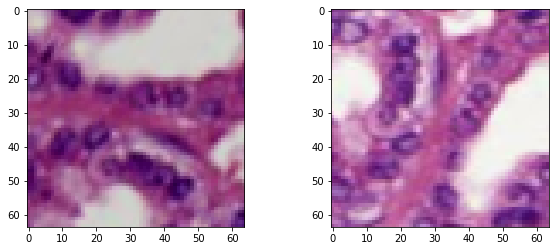

In [22]:
#visualize a single example to verify that it is correct
(img, label, img_old)=dataset["train"][100]
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing patch after augmentation and original patch
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

print(label)

In [23]:
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-2) 

In [24]:
class_weight= dataset["train"].classsizes
class_weight =torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight) 


tensor([0.8828, 0.7734, 0.9062, 0.9531, 0.7734, 0.9062, 0.8828, 0.9219],
       device='cuda:0')


In [25]:
#def trainnetwork():
writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = np.Infinity

start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases} #keep this on GPU for greatly improved performance
    cmatrix = {key: np.zeros((nclasses,nclasses)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (X, label, img_orig) in tqdm(enumerate(dataLoader[phase]),total=len(dataLoader[phase])): #for each of the batches
            X = X.to(device)  # [Nbatch, 3, H, W]
            label = label.type('torch.LongTensor').to(device)  # [Nbatch, 1] with class indices (0, 1, 2,...nclasses)

            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                prediction = model(X)  # [N, Nclass]
                loss = criterion(prediction, label)


                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction.detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=label.cpu().numpy().flatten()

                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat, labels=range(nclasses))

                writer.add_scalar(f'{phase}/batch_loss', loss.detach().cpu().numpy(), ii+batch_size*epoch)
                
                

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            for r in range(nclasses):
                for c in range(nclasses): #essentially write out confusion matrix
                    writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict()}


        torch.save(state, f"{dataname}_single_best_model.pth")
    else:
        print("")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide



2m 6s (- 522m 21s) ([1/250] 0%), train loss: 1.0780 test loss: 0.7591  **



4m 11s (- 519m 46s) ([2/250] 0%), train loss: 0.6988 test loss: 0.6478  **



6m 17s (- 517m 12s) ([3/250] 1%), train loss: 0.6157 test loss: 1.6384



8m 22s (- 514m 29s) ([4/250] 1%), train loss: 0.5782 test loss: 1.1745



10m 27s (- 512m 23s) ([5/250] 2%), train loss: 0.5439 test loss: 0.6767



12m 33s (- 510m 31s) ([6/250] 2%), train loss: 0.5130 test loss: 0.7194



14m 39s (- 508m 47s) ([7/250] 2%), train loss: 0.4841 test loss: 0.5322  **



16m 45s (- 506m 51s) ([8/250] 3%), train loss: 0.4633 test loss: 0.6671



18m 50s (- 504m 30s) ([9/250] 3%), train loss: 0.4484 test loss: 0.5397



20m 55s (- 502m 15s) ([10/250] 4%), train loss: 0.4344 test loss: 0.4391  **



23m 0s (- 499m 55s) ([11/250] 4%), train loss: 0.4276 test loss: 0.5983



25m 5s (- 497m 40s) ([12/250] 4%), train loss: 0.4208 test loss: 0.5524



27m 10s (- 495m 23s) ([13/250] 5%), train loss: 0.4133 test loss: 0.9345



29m 16s (- 493m 15s) ([14/250] 5%), train loss: 0.4112 test loss: 0.5202



31m 22s (- 491m 19s) ([15/250] 6%), train loss: 0.4019 test loss: 0.7167



33m 28s (- 489m 27s) ([16/250] 6%), train loss: 0.4028 test loss: 0.4328  **



35m 34s (- 487m 23s) ([17/250] 6%), train loss: 0.3971 test loss: 0.6306



37m 40s (- 485m 24s) ([18/250] 7%), train loss: 0.3952 test loss: 0.5757



39m 45s (- 483m 19s) ([19/250] 7%), train loss: 0.3919 test loss: 0.5672



41m 51s (- 481m 16s) ([20/250] 8%), train loss: 0.3917 test loss: 0.7529



43m 56s (- 479m 7s) ([21/250] 8%), train loss: 0.3910 test loss: 0.4933



46m 1s (- 476m 57s) ([22/250] 8%), train loss: 0.3860 test loss: 0.4515



48m 7s (- 474m 50s) ([23/250] 9%), train loss: 0.3897 test loss: 0.6344



50m 12s (- 472m 45s) ([24/250] 9%), train loss: 0.3864 test loss: 0.4094  **



52m 18s (- 470m 44s) ([25/250] 10%), train loss: 0.3828 test loss: 0.5002



54m 23s (- 468m 33s) ([26/250] 10%), train loss: 0.3832 test loss: 0.5174



56m 28s (- 466m 23s) ([27/250] 10%), train loss: 0.3857 test loss: 0.4486



58m 33s (- 464m 16s) ([28/250] 11%), train loss: 0.3764 test loss: 0.4119



60m 38s (- 462m 6s) ([29/250] 11%), train loss: 0.3809 test loss: 0.4697



62m 43s (- 459m 57s) ([30/250] 12%), train loss: 0.3766 test loss: 0.5085



64m 49s (- 457m 58s) ([31/250] 12%), train loss: 0.3777 test loss: 0.4056  **



66m 56s (- 455m 58s) ([32/250] 12%), train loss: 0.3786 test loss: 0.6255



69m 1s (- 453m 52s) ([33/250] 13%), train loss: 0.3764 test loss: 0.4417



71m 7s (- 451m 50s) ([34/250] 13%), train loss: 0.3766 test loss: 0.4116



73m 13s (- 449m 46s) ([35/250] 14%), train loss: 0.3747 test loss: 0.6182



75m 18s (- 447m 37s) ([36/250] 14%), train loss: 0.3720 test loss: 0.4539



77m 23s (- 445m 31s) ([37/250] 14%), train loss: 0.3746 test loss: 0.4373



79m 29s (- 443m 27s) ([38/250] 15%), train loss: 0.3718 test loss: 0.4523



81m 35s (- 441m 23s) ([39/250] 15%), train loss: 0.3762 test loss: 0.6148



83m 41s (- 439m 21s) ([40/250] 16%), train loss: 0.3736 test loss: 0.5783



85m 47s (- 437m 18s) ([41/250] 16%), train loss: 0.3709 test loss: 0.7874



87m 53s (- 435m 16s) ([42/250] 16%), train loss: 0.3703 test loss: 0.4485



89m 59s (- 433m 9s) ([43/250] 17%), train loss: 0.3693 test loss: 0.4618



92m 4s (- 431m 1s) ([44/250] 17%), train loss: 0.3685 test loss: 0.4853



94m 9s (- 428m 54s) ([45/250] 18%), train loss: 0.3657 test loss: 0.6567



96m 14s (- 426m 46s) ([46/250] 18%), train loss: 0.3713 test loss: 0.4925



98m 20s (- 424m 42s) ([47/250] 18%), train loss: 0.3650 test loss: 0.5128



100m 26s (- 422m 39s) ([48/250] 19%), train loss: 0.3698 test loss: 0.3866  **



102m 31s (- 420m 33s) ([49/250] 19%), train loss: 0.3646 test loss: 0.6214



104m 37s (- 418m 28s) ([50/250] 20%), train loss: 0.3673 test loss: 0.5095



106m 43s (- 416m 23s) ([51/250] 20%), train loss: 0.3681 test loss: 0.4684



108m 48s (- 414m 18s) ([52/250] 20%), train loss: 0.3648 test loss: 0.3796  **



110m 54s (- 412m 11s) ([53/250] 21%), train loss: 0.3595 test loss: 0.4572



112m 59s (- 410m 7s) ([54/250] 21%), train loss: 0.3631 test loss: 0.5818



115m 5s (- 408m 1s) ([55/250] 22%), train loss: 0.3648 test loss: 0.7228



117m 11s (- 405m 57s) ([56/250] 22%), train loss: 0.3599 test loss: 0.4650



119m 17s (- 403m 55s) ([57/250] 22%), train loss: 0.3603 test loss: 0.5335



121m 23s (- 401m 51s) ([58/250] 23%), train loss: 0.3650 test loss: 0.4576



123m 30s (- 399m 47s) ([59/250] 23%), train loss: 0.3626 test loss: 0.5598



125m 35s (- 397m 42s) ([60/250] 24%), train loss: 0.3599 test loss: 0.4625



127m 41s (- 395m 36s) ([61/250] 24%), train loss: 0.3618 test loss: 0.5230



129m 48s (- 393m 34s) ([62/250] 24%), train loss: 0.3620 test loss: 0.4349



131m 53s (- 391m 28s) ([63/250] 25%), train loss: 0.3621 test loss: 0.5506



133m 59s (- 389m 23s) ([64/250] 25%), train loss: 0.3610 test loss: 0.6633



136m 5s (- 387m 19s) ([65/250] 26%), train loss: 0.3639 test loss: 0.6144



138m 11s (- 385m 14s) ([66/250] 26%), train loss: 0.3590 test loss: 0.4819



140m 17s (- 383m 9s) ([67/250] 26%), train loss: 0.3616 test loss: 0.4743



142m 22s (- 381m 3s) ([68/250] 27%), train loss: 0.3619 test loss: 0.4827



144m 28s (- 378m 56s) ([69/250] 27%), train loss: 0.3619 test loss: 0.3872



146m 33s (- 376m 50s) ([70/250] 28%), train loss: 0.3618 test loss: 0.5148



148m 39s (- 374m 45s) ([71/250] 28%), train loss: 0.3617 test loss: 0.5589



150m 44s (- 372m 39s) ([72/250] 28%), train loss: 0.3578 test loss: 0.5265



152m 50s (- 370m 35s) ([73/250] 29%), train loss: 0.3636 test loss: 0.3925



154m 56s (- 368m 29s) ([74/250] 29%), train loss: 0.3605 test loss: 0.3960



157m 1s (- 366m 23s) ([75/250] 30%), train loss: 0.3628 test loss: 0.4392



159m 6s (- 364m 16s) ([76/250] 30%), train loss: 0.3594 test loss: 0.4636



161m 11s (- 362m 8s) ([77/250] 30%), train loss: 0.3606 test loss: 0.4127



163m 17s (- 360m 2s) ([78/250] 31%), train loss: 0.3617 test loss: 0.4746



165m 22s (- 357m 56s) ([79/250] 31%), train loss: 0.3592 test loss: 0.3708  **



167m 27s (- 355m 50s) ([80/250] 32%), train loss: 0.3613 test loss: 0.4586



169m 33s (- 353m 45s) ([81/250] 32%), train loss: 0.3592 test loss: 0.5907



171m 39s (- 351m 40s) ([82/250] 32%), train loss: 0.3593 test loss: 0.5781



173m 45s (- 349m 35s) ([83/250] 33%), train loss: 0.3612 test loss: 0.5379



175m 51s (- 347m 30s) ([84/250] 33%), train loss: 0.3611 test loss: 0.7250



177m 57s (- 345m 26s) ([85/250] 34%), train loss: 0.3569 test loss: 0.5058



180m 3s (- 343m 22s) ([86/250] 34%), train loss: 0.3579 test loss: 0.4631



182m 9s (- 341m 16s) ([87/250] 34%), train loss: 0.3633 test loss: 0.4769



184m 15s (- 339m 12s) ([88/250] 35%), train loss: 0.3596 test loss: 0.5378



186m 22s (- 337m 7s) ([89/250] 35%), train loss: 0.3618 test loss: 0.4128



188m 27s (- 335m 1s) ([90/250] 36%), train loss: 0.3576 test loss: 0.5056



190m 33s (- 332m 56s) ([91/250] 36%), train loss: 0.3571 test loss: 0.4662



192m 39s (- 330m 50s) ([92/250] 36%), train loss: 0.3571 test loss: 0.6240



194m 44s (- 328m 44s) ([93/250] 37%), train loss: 0.3579 test loss: 0.4308



196m 50s (- 326m 39s) ([94/250] 37%), train loss: 0.3592 test loss: 0.6978



198m 56s (- 324m 35s) ([95/250] 38%), train loss: 0.3611 test loss: 0.5053



201m 2s (- 322m 29s) ([96/250] 38%), train loss: 0.3548 test loss: 0.4409



203m 9s (- 320m 25s) ([97/250] 38%), train loss: 0.3562 test loss: 0.7690



205m 14s (- 318m 19s) ([98/250] 39%), train loss: 0.3561 test loss: 0.4871



207m 19s (- 316m 12s) ([99/250] 39%), train loss: 0.3533 test loss: 0.4558



209m 24s (- 314m 6s) ([100/250] 40%), train loss: 0.3548 test loss: 0.4110



211m 30s (- 312m 0s) ([101/250] 40%), train loss: 0.3548 test loss: 0.4943



213m 36s (- 309m 55s) ([102/250] 40%), train loss: 0.3558 test loss: 0.4708



215m 41s (- 307m 49s) ([103/250] 41%), train loss: 0.3557 test loss: 0.4428



217m 48s (- 305m 44s) ([104/250] 41%), train loss: 0.3541 test loss: 0.5539



219m 54s (- 303m 39s) ([105/250] 42%), train loss: 0.3609 test loss: 0.5691



222m 0s (- 301m 35s) ([106/250] 42%), train loss: 0.3576 test loss: 0.4164



224m 7s (- 299m 30s) ([107/250] 42%), train loss: 0.3550 test loss: 0.3998



226m 13s (- 297m 25s) ([108/250] 43%), train loss: 0.3550 test loss: 0.5859



228m 18s (- 295m 19s) ([109/250] 43%), train loss: 0.3578 test loss: 1.1242



230m 23s (- 293m 12s) ([110/250] 44%), train loss: 0.3548 test loss: 0.4906



232m 29s (- 291m 6s) ([111/250] 44%), train loss: 0.3514 test loss: 0.4343



234m 34s (- 289m 1s) ([112/250] 44%), train loss: 0.3549 test loss: 0.4425



236m 40s (- 286m 55s) ([113/250] 45%), train loss: 0.3571 test loss: 0.4148



238m 46s (- 284m 50s) ([114/250] 45%), train loss: 0.3530 test loss: 0.5300



240m 52s (- 282m 44s) ([115/250] 46%), train loss: 0.3560 test loss: 0.4626



242m 58s (- 280m 39s) ([116/250] 46%), train loss: 0.3575 test loss: 0.9639



245m 4s (- 278m 34s) ([117/250] 46%), train loss: 0.3539 test loss: 0.5091



247m 9s (- 276m 28s) ([118/250] 47%), train loss: 0.3546 test loss: 0.6883



249m 14s (- 274m 22s) ([119/250] 47%), train loss: 0.3585 test loss: 0.4962



251m 20s (- 272m 16s) ([120/250] 48%), train loss: 0.3534 test loss: 0.9738



253m 25s (- 270m 10s) ([121/250] 48%), train loss: 0.3537 test loss: 0.4165



255m 31s (- 268m 4s) ([122/250] 48%), train loss: 0.3552 test loss: 0.4421



257m 36s (- 265m 58s) ([123/250] 49%), train loss: 0.3530 test loss: 0.4416



259m 41s (- 263m 52s) ([124/250] 49%), train loss: 0.3535 test loss: 0.5069



261m 47s (- 261m 46s) ([125/250] 50%), train loss: 0.3506 test loss: 0.3916



263m 52s (- 259m 40s) ([126/250] 50%), train loss: 0.3537 test loss: 0.4843



265m 57s (- 257m 34s) ([127/250] 50%), train loss: 0.3560 test loss: 0.4942



268m 3s (- 255m 28s) ([128/250] 51%), train loss: 0.3545 test loss: 0.4220



270m 8s (- 253m 22s) ([129/250] 51%), train loss: 0.3510 test loss: 0.5895



272m 14s (- 251m 16s) ([130/250] 52%), train loss: 0.3528 test loss: 0.5125



274m 20s (- 249m 11s) ([131/250] 52%), train loss: 0.3513 test loss: 0.4332



276m 26s (- 247m 6s) ([132/250] 52%), train loss: 0.3547 test loss: 0.4886



278m 32s (- 245m 1s) ([133/250] 53%), train loss: 0.3563 test loss: 0.6550



280m 38s (- 242m 56s) ([134/250] 53%), train loss: 0.3537 test loss: 0.5458



282m 44s (- 240m 50s) ([135/250] 54%), train loss: 0.3503 test loss: 1.9338



284m 49s (- 238m 44s) ([136/250] 54%), train loss: 0.3522 test loss: 0.5438



286m 55s (- 236m 39s) ([137/250] 54%), train loss: 0.3553 test loss: 0.5380



289m 2s (- 234m 34s) ([138/250] 55%), train loss: 0.3548 test loss: 0.4247



291m 8s (- 232m 28s) ([139/250] 55%), train loss: 0.3559 test loss: 0.4899



293m 13s (- 230m 23s) ([140/250] 56%), train loss: 0.3490 test loss: 0.6071



295m 19s (- 228m 17s) ([141/250] 56%), train loss: 0.3515 test loss: 0.4868



297m 24s (- 226m 11s) ([142/250] 56%), train loss: 0.3511 test loss: 0.4036



299m 30s (- 224m 6s) ([143/250] 57%), train loss: 0.3495 test loss: 0.4007



301m 36s (- 222m 0s) ([144/250] 57%), train loss: 0.3478 test loss: 0.4445



303m 42s (- 219m 55s) ([145/250] 57%), train loss: 0.3503 test loss: 0.4056



305m 49s (- 217m 50s) ([146/250] 58%), train loss: 0.3523 test loss: 0.5463



307m 54s (- 215m 44s) ([147/250] 58%), train loss: 0.3499 test loss: 0.5326



309m 58s (- 213m 37s) ([148/250] 59%), train loss: 0.3495 test loss: 0.4221



312m 4s (- 211m 31s) ([149/250] 59%), train loss: 0.3528 test loss: 0.4695



314m 9s (- 209m 25s) ([150/250] 60%), train loss: 0.3519 test loss: 0.3867



316m 15s (- 207m 20s) ([151/250] 60%), train loss: 0.3494 test loss: 0.4152



318m 21s (- 205m 14s) ([152/250] 60%), train loss: 0.3500 test loss: 0.4263



320m 26s (- 203m 8s) ([153/250] 61%), train loss: 0.3526 test loss: 0.4852



322m 32s (- 201m 3s) ([154/250] 61%), train loss: 0.3515 test loss: 0.5259



324m 38s (- 198m 57s) ([155/250] 62%), train loss: 0.3460 test loss: 0.6142



326m 44s (- 196m 52s) ([156/250] 62%), train loss: 0.3480 test loss: 0.4241



328m 50s (- 194m 47s) ([157/250] 62%), train loss: 0.3515 test loss: 0.4827



330m 56s (- 192m 41s) ([158/250] 63%), train loss: 0.3495 test loss: 0.4229



333m 1s (- 190m 35s) ([159/250] 63%), train loss: 0.3518 test loss: 0.4614



335m 7s (- 188m 30s) ([160/250] 64%), train loss: 0.3487 test loss: 0.3742



337m 13s (- 186m 24s) ([161/250] 64%), train loss: 0.3514 test loss: 0.4312



339m 19s (- 184m 18s) ([162/250] 64%), train loss: 0.3509 test loss: 0.5325



341m 25s (- 182m 13s) ([163/250] 65%), train loss: 0.3489 test loss: 0.5886



343m 31s (- 180m 7s) ([164/250] 65%), train loss: 0.3554 test loss: 0.3903



345m 37s (- 178m 2s) ([165/250] 66%), train loss: 0.3533 test loss: 0.5353



347m 43s (- 175m 57s) ([166/250] 66%), train loss: 0.3476 test loss: 0.7854



349m 49s (- 173m 51s) ([167/250] 66%), train loss: 0.3471 test loss: 0.4420



351m 55s (- 171m 45s) ([168/250] 67%), train loss: 0.3509 test loss: 0.3807



354m 1s (- 169m 40s) ([169/250] 67%), train loss: 0.3516 test loss: 0.5153



356m 6s (- 167m 34s) ([170/250] 68%), train loss: 0.3469 test loss: 0.4179



358m 12s (- 165m 28s) ([171/250] 68%), train loss: 0.3526 test loss: 0.7635



360m 18s (- 163m 23s) ([172/250] 68%), train loss: 0.3500 test loss: 0.4008



362m 25s (- 161m 18s) ([173/250] 69%), train loss: 0.3489 test loss: 0.3863



364m 31s (- 159m 12s) ([174/250] 69%), train loss: 0.3499 test loss: 0.4111



366m 38s (- 157m 7s) ([175/250] 70%), train loss: 0.3483 test loss: 0.4995



368m 44s (- 155m 1s) ([176/250] 70%), train loss: 0.3488 test loss: 0.3813



370m 50s (- 152m 56s) ([177/250] 70%), train loss: 0.3493 test loss: 0.4070



372m 56s (- 150m 50s) ([178/250] 71%), train loss: 0.3484 test loss: 0.4409



375m 2s (- 148m 45s) ([179/250] 71%), train loss: 0.3480 test loss: 0.7170



377m 8s (- 146m 39s) ([180/250] 72%), train loss: 0.3484 test loss: 0.4801



379m 15s (- 144m 34s) ([181/250] 72%), train loss: 0.3457 test loss: 0.4195



381m 21s (- 142m 28s) ([182/250] 72%), train loss: 0.3460 test loss: 0.3822



383m 28s (- 140m 23s) ([183/250] 73%), train loss: 0.3466 test loss: 0.5940



385m 34s (- 138m 17s) ([184/250] 73%), train loss: 0.3474 test loss: 0.5591



387m 40s (- 136m 12s) ([185/250] 74%), train loss: 0.3508 test loss: 0.4131



389m 47s (- 134m 6s) ([186/250] 74%), train loss: 0.3472 test loss: 0.4165



391m 53s (- 132m 1s) ([187/250] 74%), train loss: 0.3480 test loss: 0.5686



394m 0s (- 129m 55s) ([188/250] 75%), train loss: 0.3478 test loss: 0.4287



396m 6s (- 127m 50s) ([189/250] 75%), train loss: 0.3497 test loss: 0.4338



398m 12s (- 125m 44s) ([190/250] 76%), train loss: 0.3443 test loss: 0.4613



400m 19s (- 123m 39s) ([191/250] 76%), train loss: 0.3479 test loss: 0.5893



402m 24s (- 121m 33s) ([192/250] 76%), train loss: 0.3463 test loss: 0.3618  **



404m 30s (- 119m 27s) ([193/250] 77%), train loss: 0.3479 test loss: 0.6445



406m 35s (- 117m 21s) ([194/250] 77%), train loss: 0.3470 test loss: 0.5567



408m 41s (- 115m 15s) ([195/250] 78%), train loss: 0.3494 test loss: 0.5515



410m 47s (- 113m 10s) ([196/250] 78%), train loss: 0.3484 test loss: 0.5494



412m 53s (- 111m 4s) ([197/250] 78%), train loss: 0.3536 test loss: 0.4958



414m 59s (- 108m 58s) ([198/250] 79%), train loss: 0.3473 test loss: 0.7585



417m 7s (- 106m 53s) ([199/250] 79%), train loss: 0.3486 test loss: 0.5279



419m 13s (- 104m 48s) ([200/250] 80%), train loss: 0.3457 test loss: 0.4787



421m 19s (- 102m 42s) ([201/250] 80%), train loss: 0.3453 test loss: 0.3965



423m 26s (- 100m 36s) ([202/250] 80%), train loss: 0.3504 test loss: 0.4630



425m 33s (- 98m 31s) ([203/250] 81%), train loss: 0.3500 test loss: 0.4961



427m 39s (- 96m 25s) ([204/250] 81%), train loss: 0.3448 test loss: 0.5280



429m 45s (- 94m 19s) ([205/250] 82%), train loss: 0.3487 test loss: 0.6272



431m 52s (- 92m 14s) ([206/250] 82%), train loss: 0.3516 test loss: 0.4825



433m 58s (- 90m 8s) ([207/250] 82%), train loss: 0.3478 test loss: 0.4369



436m 4s (- 88m 2s) ([208/250] 83%), train loss: 0.3513 test loss: 0.6068



438m 11s (- 85m 57s) ([209/250] 83%), train loss: 0.3494 test loss: 0.4263



440m 17s (- 83m 51s) ([210/250] 84%), train loss: 0.3497 test loss: 0.5009



442m 23s (- 81m 45s) ([211/250] 84%), train loss: 0.3480 test loss: 0.4883



444m 29s (- 79m 40s) ([212/250] 84%), train loss: 0.3495 test loss: 0.3756



446m 36s (- 77m 34s) ([213/250] 85%), train loss: 0.3501 test loss: 0.6041



448m 42s (- 75m 28s) ([214/250] 85%), train loss: 0.3463 test loss: 0.5051



450m 47s (- 73m 22s) ([215/250] 86%), train loss: 0.3485 test loss: 0.3548  **



452m 52s (- 71m 16s) ([216/250] 86%), train loss: 0.3519 test loss: 0.4908



454m 58s (- 69m 11s) ([217/250] 86%), train loss: 0.3469 test loss: 0.3754



457m 4s (- 67m 5s) ([218/250] 87%), train loss: 0.3473 test loss: 0.4402



459m 10s (- 64m 59s) ([219/250] 87%), train loss: 0.3480 test loss: 0.4848



461m 17s (- 62m 53s) ([220/250] 88%), train loss: 0.3492 test loss: 0.3474  **



463m 23s (- 60m 48s) ([221/250] 88%), train loss: 0.3499 test loss: 0.6546



465m 29s (- 58m 42s) ([222/250] 88%), train loss: 0.3497 test loss: 0.5820



467m 34s (- 56m 36s) ([223/250] 89%), train loss: 0.3461 test loss: 0.5237



469m 41s (- 54m 30s) ([224/250] 89%), train loss: 0.3486 test loss: 0.4130



471m 48s (- 52m 25s) ([225/250] 90%), train loss: 0.3509 test loss: 0.6328



473m 54s (- 50m 19s) ([226/250] 90%), train loss: 0.3486 test loss: 0.4404



476m 0s (- 48m 13s) ([227/250] 90%), train loss: 0.3486 test loss: 0.4124



478m 6s (- 46m 7s) ([228/250] 91%), train loss: 0.3493 test loss: 0.7568



480m 12s (- 44m 1s) ([229/250] 91%), train loss: 0.3465 test loss: 0.4101



482m 19s (- 41m 56s) ([230/250] 92%), train loss: 0.3499 test loss: 0.4544



484m 25s (- 39m 50s) ([231/250] 92%), train loss: 0.3474 test loss: 0.7483



486m 30s (- 37m 44s) ([232/250] 92%), train loss: 0.3498 test loss: 0.5354



488m 36s (- 35m 38s) ([233/250] 93%), train loss: 0.3478 test loss: 0.4081



490m 42s (- 33m 32s) ([234/250] 93%), train loss: 0.3468 test loss: 0.4629



492m 49s (- 31m 27s) ([235/250] 94%), train loss: 0.3501 test loss: 0.4800



494m 54s (- 29m 21s) ([236/250] 94%), train loss: 0.3447 test loss: 0.4212



497m 0s (- 27m 15s) ([237/250] 94%), train loss: 0.3508 test loss: 0.4042



499m 6s (- 25m 9s) ([238/250] 95%), train loss: 0.3463 test loss: 0.3754



501m 12s (- 23m 3s) ([239/250] 95%), train loss: 0.3484 test loss: 0.4100



503m 18s (- 20m 57s) ([240/250] 96%), train loss: 0.3490 test loss: 0.3934



505m 24s (- 18m 52s) ([241/250] 96%), train loss: 0.3499 test loss: 0.5031



507m 30s (- 16m 46s) ([242/250] 96%), train loss: 0.3504 test loss: 0.4427



509m 36s (- 14m 40s) ([243/250] 97%), train loss: 0.3458 test loss: 0.5119



511m 43s (- 12m 34s) ([244/250] 97%), train loss: 0.3450 test loss: 0.5405



513m 49s (- 10m 28s) ([245/250] 98%), train loss: 0.3493 test loss: 0.5669



515m 56s (- 8m 23s) ([246/250] 98%), train loss: 0.3474 test loss: 0.5346



518m 2s (- 6m 17s) ([247/250] 98%), train loss: 0.3464 test loss: 0.3786



520m 8s (- 4m 11s) ([248/250] 99%), train loss: 0.3478 test loss: 0.3516



522m 14s (- 2m 5s) ([249/250] 99%), train loss: 0.3449 test loss: 0.3683



524m 20s (- -1m 59s) ([250/250] 100%), train loss: 0.3469 test loss: 0.4486


In [26]:
!tensorboard --logdir runs 

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.0.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C
